<h2>1. Contexte<h2/>

<h2>This notebook is dedicated to understanding the subject and exploring the data.<h2/>

<h3>"The dataset includes 174 metrics and 297,099 rows of data of tropical storms in the United States
collected from 1980 onwards. The data is raw, imperfect, and has not been cleaned or preprocessed."<h3/>

<h3>"Information about the dataset attributes can be found in the IBTRACS_variable_documentation file. Using the provided dataset, you are asked to train a model to predict the severity of a tropical cyclone based on geographical input data."<h3/>

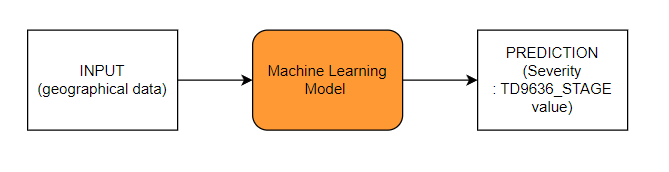

We want to predict the 145th column of the dataset 

<h2>2. Data Exploration<h2/>

In [552]:
#Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [553]:
#Import and read the csv file. We remove the first line (with skiprows) because it contains the header units. Display the 3 first rows.

df = pd.read_csv("ibtracs.csv", skiprows=[1])
df.head(3)

C:\Users\paulv\AppData\Local\Temp\ipykernel_19492\2370999850.py:3: DtypeWarning: Columns (19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.csv", skiprows=[1])


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,,,,,,,,,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,,,,,,,,,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,,,,,,,,,5,360


In [554]:
df.shape

(297098, 174)

In [555]:
# In the CSV file, we can see that many values consist of just a space (" "). We need to replace them with NaN

df.replace(" ", np.nan, inplace=True)
df.head(3)

C:\Users\paulv\AppData\Local\Temp\ipykernel_19492\4256441436.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(" ", np.nan, inplace=True)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,360


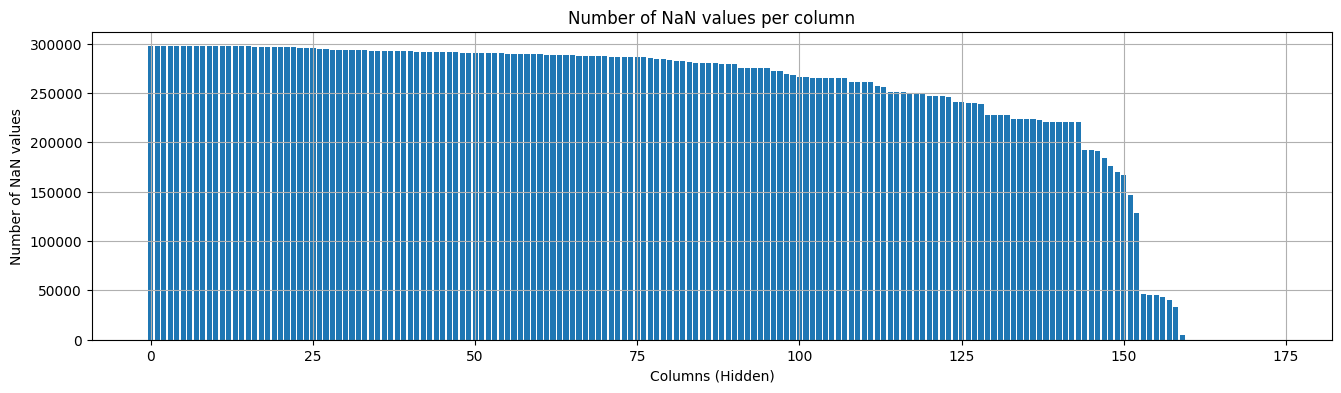

In [556]:
# Identification of columns with 0 good values, we can plot this to take a look

nan_counts = df.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(16, 4))
plt.grid()
plt.bar(range(len(nan_counts)), nan_counts.values) 

# Labels et titles
plt.xlabel("Columns (Hidden)")
plt.ylabel("Number of NaN values")
plt.title("Number of NaN values per column")

plt.show()

<h2>We need to focus on TD9636_STAGE values, it's the prediction</h2>

In [557]:
df_y = df["TD9636_STAGE"]
df_y

0           1
1           1
2           1
3           1
4           1
         ... 
297093    NaN
297094    NaN
297095    NaN
297096    NaN
297097    NaN
Name: TD9636_STAGE, Length: 297098, dtype: object

In [558]:
df_y.value_counts()

TD9636_STAGE
2    17204
1    16028
4    10623
0     3156
3      742
5      331
6      259
Name: count, dtype: int64

In [559]:
missing_values_y = df_y.isna().sum()

print(f"We have {missing_values_y / df.shape[0] * 100} % of missing values in TD9636_STAGE")

We have 83.72826474765903 % of missing values in TD9636_STAGE


In [560]:
# 83,7% is very important, we can't fill the missing values. 
# So, we need to delete rows where there are missing values.

df = df.dropna(subset=['TD9636_STAGE'])


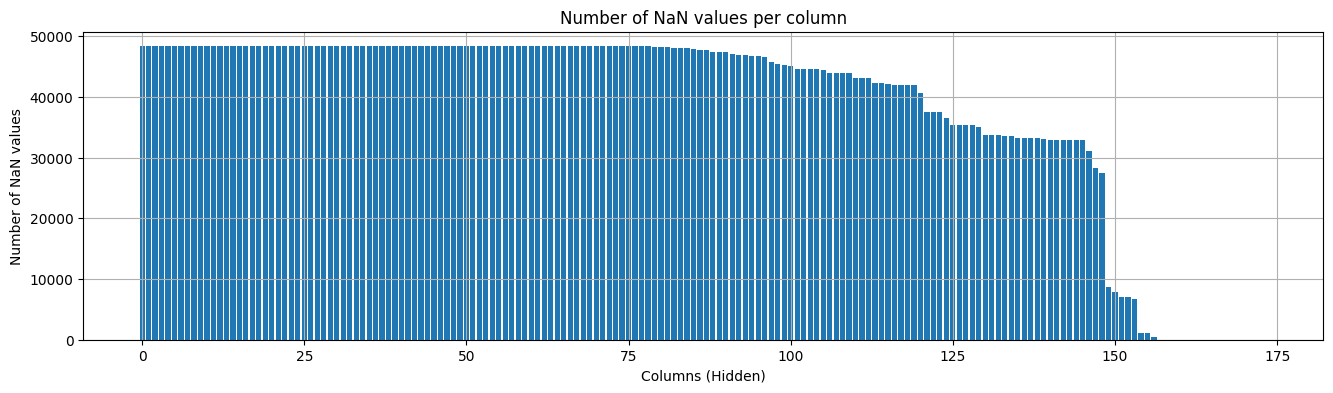

In [561]:
# We can plot again

nan_counts = df.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(16, 4))
plt.grid()
plt.bar(range(len(nan_counts)), nan_counts.values) 

# Labels et titles
plt.xlabel("Columns (Hidden)")
plt.ylabel("Number of NaN values")
plt.title("Number of NaN values per column")

plt.show()

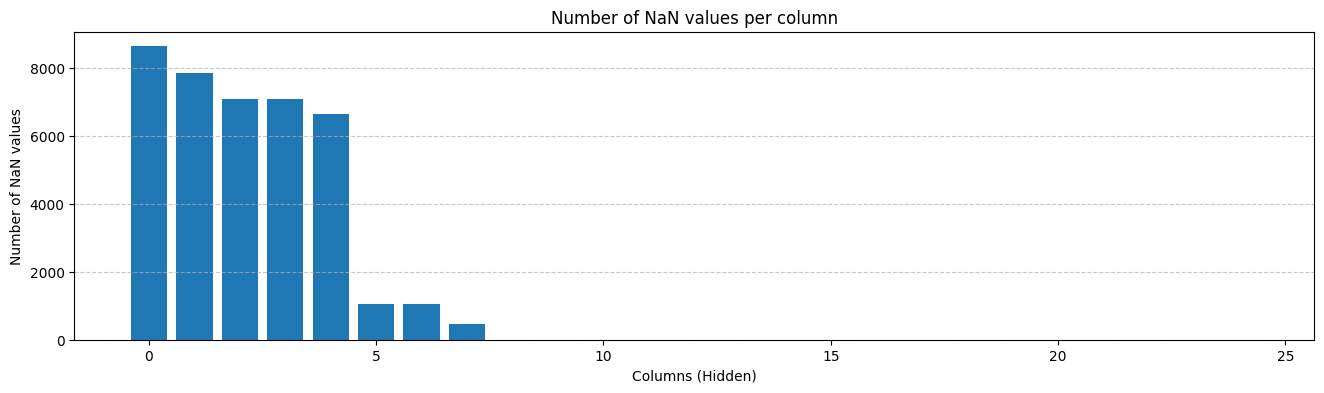

In [562]:
# Threshold for column removal: If a column has more than 30% missing values (NaN), 
# we consider it unusable and remove it. This threshold can be adjusted later if needed.

threshold = 0.3 * df.shape[0] # 0.3 * 48343 = 14502.9

cols_to_drop = df.columns[df.isna().sum() > threshold]
df= df.drop(columns=cols_to_drop)

nan_counts_cleaned = df.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(16, 4))
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.bar(range(len(nan_counts_cleaned)), nan_counts_cleaned.values) 

# Labels et titles
plt.xlabel("Columns (Hidden)")
plt.ylabel("Number of NaN values")
plt.title("Number of NaN values per column")

plt.show()



<h3>So we have 10 columns with missing values</h3>

In [563]:
df.head(3)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,USA_LAT,USA_LON,USA_WIND,USA_SSHS,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,-12.5,172.5,25,-1,-12.5,172.5,1,25,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,-12.2,172.4,25,-1,-12.2,172.5,1,NaN,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,-11.9,172.4,25,-1,-12.0,172.4,1,NaN,5,360


In [564]:
df.shape

(48343, 25)

In [565]:
# If a column contains only one unique value, we could remove it, but that is not the case.

unique_counts = df.nunique()
unique_counts

SID               793
SEASON             10
NUMBER            125
BASIN               5
SUBBASIN            6
NAME              453
ISO_TIME        24417
NATURE              5
LAT               862
LON              2605
TRACK_TYPE          4
DIST2LAND        3034
LANDFALL         3012
IFLAG             302
USA_ATCF_ID       772
USA_LAT           804
USA_LON          2356
USA_WIND          112
USA_SSHS           10
TD9636_LAT        836
TD9636_LON       2374
TD9636_STAGE        7
TD9636_WIND       140
STORM_SPEED       123
STORM_DIR         146
dtype: int64

In [566]:
# With the documentation, we can see that some values are not marked as NaN but are equivalent. For example, 'MM' in SUBBASIN corresponds to missing.
# We need to fix that

df["SUBBASIN"] = df["SUBBASIN"].replace("MM", np.nan)
df["BASIN"] = df["BASIN"].replace("MM", np.nan)
df["NATURE"] = df["NATURE"].replace("NR", np.nan)
df["USA_SSHS"] = df["NATURE"].replace("-5", np.nan)



In [567]:
# We can display columns with NaN values et the number. 

nan_counts = df.isna().sum()
nan_columns = nan_counts[nan_counts > 0]

print(nan_columns.sort_values(ascending=False))

SUBBASIN       38602
TD9636_WIND     8647
USA_WIND        7876
USA_LAT         7083
USA_LON         7083
USA_ATCF_ID     6652
TD9636_LAT      1042
TD9636_LON      1042
LANDFALL         450
NATURE           130
USA_SSHS         130
STORM_SPEED        1
STORM_DIR          1
dtype: int64


In [568]:
treshold = df.shape[0]* 0.3 #14502.9

# We can see that SUBBASIN have too much NaN values compare to the treshold, so we can drop the SUBBASIN column

df = df.drop(columns=["SUBBASIN"])


In [569]:
nan_counts = df.isna().sum()
nan_columns = nan_counts[nan_counts > 0]

print(nan_columns.sort_values(ascending=False))

TD9636_WIND    8647
USA_WIND       7876
USA_LAT        7083
USA_LON        7083
USA_ATCF_ID    6652
TD9636_LAT     1042
TD9636_LON     1042
LANDFALL        450
NATURE          130
USA_SSHS        130
STORM_SPEED       1
STORM_DIR         1
dtype: int64


In [570]:
# We will try to identify matrices that are potentially highly correlated with each other and remove one of the columns to avoid redundancy.

df_nan = df[nan_columns.index]

df_nan.head(3)


,NATURE,LANDFALL,USA_ATCF_ID,USA_LAT,USA_LON,USA_WIND,USA_SSHS,TD9636_LAT,TD9636_LON,TD9636_WIND,STORM_SPEED,STORM_DIR
0,TS,647,SH051980,-12.5,172.5,25,TS,-12.5,172.5,25,6,350
1,TS,653,SH051980,-12.2,172.4,25,TS,-12.2,172.5,NaN,6,350
2,TS,670,SH051980,-11.9,172.4,25,TS,-12.0,172.4,NaN,5,360


In [571]:
# We need to numerize "USA_SSHS", "NATURE" and "USA_ATCF_ID".
# Using a fixed mapping for categorical columns to ensure consistency

mappings = {}

for col in ['USA_SSHS', 'NATURE', 'USA_ATCF_ID']:
    unique_values = df_nan[col].unique()
    mappings[col] = {val: idx for idx, val in enumerate(unique_values)}

for col in mappings:
    df_nan[col] = df_nan[col].map(mappings[col])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_nan = pd.DataFrame(scaler.fit_transform(df_nan), columns=df_nan.columns)

df_nan.head(3)




C:\Users\paulv\AppData\Local\Temp\ipykernel_19492\136486527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan[col] = df_nan[col].map(mappings[col])
C:\Users\paulv\AppData\Local\Temp\ipykernel_19492\136486527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan[col] = df_nan[col].map(mappings[col])
C:\Users\paulv\AppData\Local\Temp\ipykernel_19492\136486527.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,NATURE,LANDFALL,USA_ATCF_ID,USA_LAT,USA_LON,USA_WIND,USA_SSHS,TD9636_LAT,TD9636_LON,TD9636_WIND,STORM_SPEED,STORM_DIR
0,0.0,0.137806,0.0,0.377644,0.979167,0.103448,0.0,0.378788,0.979167,0.133333,0.086957,0.972222
1,0.0,0.139084,0.0,0.380665,0.978889,0.103448,0.0,0.381818,0.979167,NaN,0.086957,0.972222
2,0.0,0.142705,0.0,0.383686,0.978889,0.103448,0.0,0.383838,0.978889,NaN,0.072464,1.000000


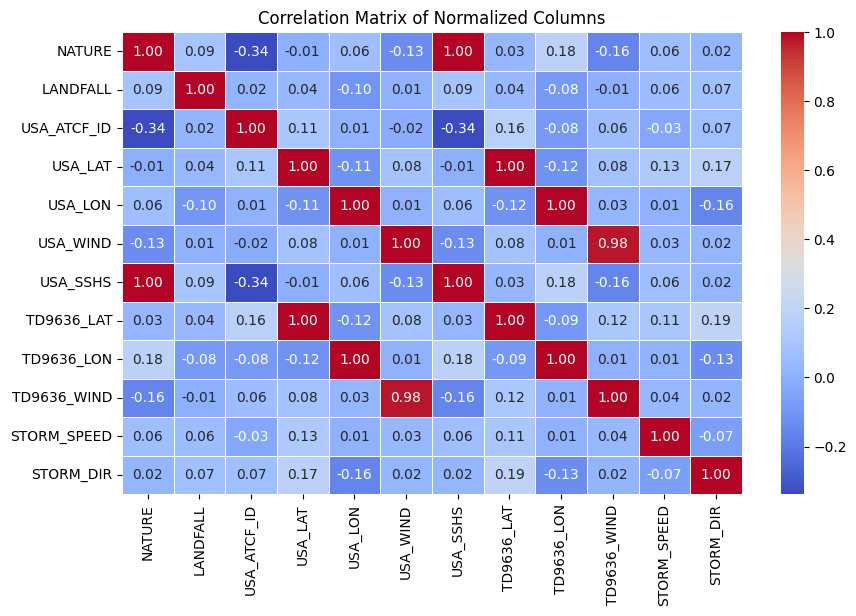

In [572]:
# Display of the correlation matrix
correlation_matrix = df_nan.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix of Normalized Columns")
plt.show()


In [573]:
# There are correlations of 1 or very close to 1 (0.98), which means that these columns are almost identical and logically related.
# Therefore, it makes sense to delete TD9636_WIND and keep USA_WIND, as their correlation is 1.
# It is preferable to remove TD9636_WIND in this case because, according to the documentation, this value is an estimate, whereas USA_WIND is not.
# For longitude and latitude, we keep the columns with fewer missing values, which will simplify the process later on.
# Finally, I decide to keep USA_SSHS rather than NATURE because USA_SSHS is already numerical in the DataFrame, making it simpler to work with.

df= df.drop(columns=["TD9636_WIND", "USA_LON","USA_LAT", "NATURE"])

In [574]:
df.shape

(48343, 20)

In [575]:
# We have already done a good selection of columns. To further refine our selection,  
# we will dive into the documentation to identify potentially useless columns  
# that, logically, will not be useful for prediction.  
# Identify columns that do not provide useful information (e.g., identifiers, internal codes, metadata).

df.nunique()

SID               793
SEASON             10
NUMBER            125
BASIN               5
NAME              453
ISO_TIME        24417
LAT               862
LON              2605
TRACK_TYPE          4
DIST2LAND        3034
LANDFALL         3012
IFLAG             302
USA_ATCF_ID       772
USA_WIND          112
USA_SSHS            4
TD9636_LAT        836
TD9636_LON       2374
TD9636_STAGE        7
STORM_SPEED       123
STORM_DIR         146
dtype: int64

In [576]:
# We have identified columns that do not provide any useful information:  
# SID (Storm ID), NAME, USA_ATCF_ID, IFLAG, TRACK_TYPE


df= df.drop(columns=["SID","NAME","NUMBER","USA_ATCF_ID","IFLAG","TRACK_TYPE"])

In [577]:
df.head()

,SEASON,BASIN,ISO_TIME,LAT,LON,DIST2LAND,LANDFALL,USA_WIND,USA_SSHS,TD9636_LAT,TD9636_LON,TD9636_STAGE,STORM_SPEED,STORM_DIR
0,1980,SP,1980-01-01 00:00:00,-12.5,172.5,647,647,25,TS,-12.5,172.5,1,6,350
1,1980,SP,1980-01-01 03:00:00,-12.2,172.4,653,653,25,TS,-12.2,172.5,1,6,350
2,1980,SP,1980-01-01 06:00:00,-11.9,172.4,670,670,25,TS,-12.0,172.4,1,5,360
3,1980,SP,1980-01-01 09:00:00,-11.7,172.4,682,682,25,TS,-11.7,172.5,1,4,10
4,1980,SP,1980-01-01 12:00:00,-11.5,172.5,703,703,25,TS,-11.5,172.5,1,4,20


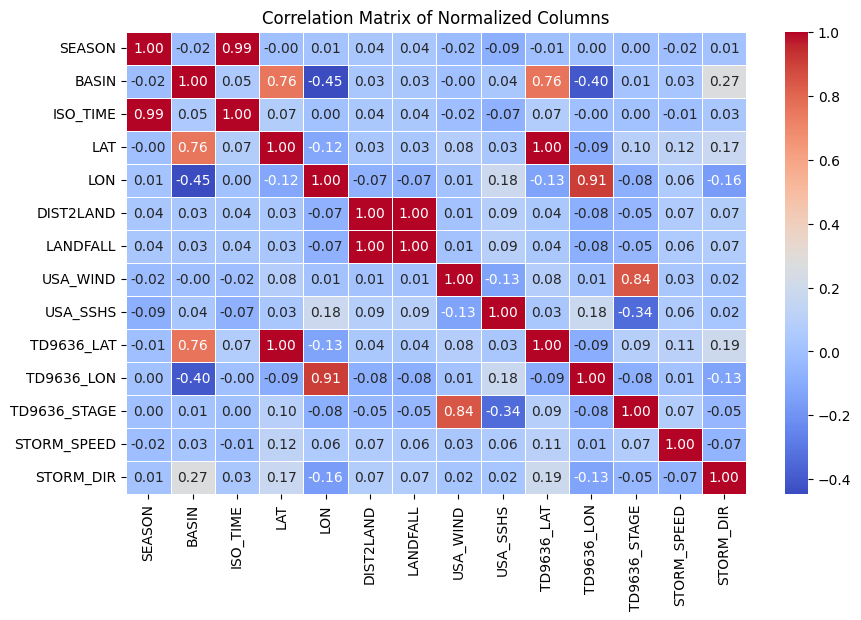

In [578]:
# Correlation Matrix of the entire df

mappings = {}

df_corr = df.copy()

for col in ['BASIN',"ISO_TIME","USA_SSHS"]:
    unique_values = df_corr[col].unique()
    mappings[col] = {val: idx for idx, val in enumerate(unique_values)}

for col in mappings:
    df_corr[col] = df_corr[col].map(mappings[col])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_corr = pd.DataFrame(scaler.fit_transform(df_corr), columns=df_corr.columns)

df_corr.head(3)

correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix of Normalized Columns")
plt.show()

In [579]:
# Quick reminder of missing values

nan_counts = df.isna().sum()
nan_columns = nan_counts[nan_counts > 0]

print(nan_columns.sort_values(ascending=False))

USA_WIND       7876
TD9636_LON     1042
TD9636_LAT     1042
LANDFALL        450
USA_SSHS        130
STORM_SPEED       1
STORM_DIR         1
dtype: int64


In [580]:
# Same process as above, we can delete one column for each strong correlation.  
# Removing ISO_TIME because it is redundant with SEASON, and SEASON is simplified, making it preferable.  
# LANDFALL is the same as DIST2LAND but contains missing values.  
# USA_WIND is very close to TD9636_STAGE, but it has missing values, so we can remove USA_WIND.  

df= df.drop(columns=["ISO_TIME", "TD9636_LON", "TD9636_LAT", "LANDFALL", "USA_WIND" ])

In [581]:
# Quick reminder of missing values

nan_counts = df.isna().sum()
nan_columns = nan_counts[nan_counts > 0]

print(nan_columns.sort_values(ascending=False))

USA_SSHS       130
STORM_SPEED      1
STORM_DIR        1
dtype: int64


In [582]:
# So now, we have only 2 NaN values in our DataFrame when the shape is (48343,10),  
# which is good for training a model.  
# Let's find the rows where values are missing. It seems to be a single row. Let's remove it.  
 

df_missing = df[df["STORM_SPEED"].isna() & df["STORM_DIR"].isna()]
print(df_missing)


       SEASON BASIN   LAT    LON  DIST2LAND USA_SSHS TD9636_STAGE STORM_SPEED  \
22705    1983    WP  14.5  141.5       1747       DS            0         NaN   

      STORM_DIR  
22705       NaN  


In [583]:
df = df.dropna(subset=["STORM_SPEED", "STORM_DIR"])


In [584]:
df.head(5)

,SEASON,BASIN,LAT,LON,DIST2LAND,USA_SSHS,TD9636_STAGE,STORM_SPEED,STORM_DIR
0,1980,SP,-12.5,172.5,647,TS,1,6,350
1,1980,SP,-12.2,172.4,653,TS,1,6,350
2,1980,SP,-11.9,172.4,670,TS,1,5,360
3,1980,SP,-11.7,172.4,682,TS,1,4,10
4,1980,SP,-11.5,172.5,703,TS,1,4,20


In [585]:
df.to_csv("dataset_TropicalStorms.csv", index=False)
